# Commodity short-term basis reversal

In this notebook, we try to replicate the shor-term basis reversal effect studied in Rossi 2025. They found that the short-term basis reversal can predict commodity returns of both long-only and calendar spreads. They also claim that the signal works in the context of both time-series and cross-section.

In [1]:
from datetime import datetime
from itertools import product
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import pytz
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.style.use('bmh')

from vivace.backtest import signal
from vivace.backtest.analytics import rebase
from vivace.backtest.contract import all_futures_rossi2025, InstrumentDef
from vivace.backtest.engine import BacktestEngine
from vivace.backtest.stats import Performance, PerfStats
from vivace.enums import Strategy, Weighting

# Data

The paper investigates the following 22 commodity futures.

In [2]:
all_futures_rossi2025

,name
ticker,
HO,Heating Oil
XB,Gasoline
CL,WTI Crude Oil
NG,Natural Gas
HG,Copper
GC,Gold
SI,Silver
FC,Feeder Cattle
LH,Lean Hog


# Performance

## Cross-sectional outright strategy

The short-term reversal strategy is a weekly-rebalanced strategy. 

Following the study from Boons and Prado 2019 in Basis Momentum, the core signal is based on the difference between the front futures and the second futures which is defined as follows:

$$
SRet_t^{F_1 - F_2} = Ret_t^{F_1} - Ret_t^{F_2}
$$

where
- $Ret_t^{F_1}$ is the return on week $t$ for $F_1$
- $Ret_t^{F_2}$ is the return on week $t$ for $F_2$.

$F_1$ and $F_2$ are the first and second contract respectively. Futures are rolled one month before the expiry date. To achieve the same effect, futures are rolled 21 days before respecitve first notice dates as specified in `roll_schedule=21`. 

In the original study, it appears that the analysis was done using weekly returns (the subscript $t$ above refers to weeks). This implies that investments done at the end of week $t$ is based on information up to the same $t$ which is not attainable in practice. Settlement prices on $t$ are only available after the fact. Additionally given this is a cross-sectional strategy across multiple exchanges, information for all futures needs to be available in order to form a portfolio on week $t$. If the analysis is done only using weekly observations there's a possible look-ahead bias. To alleviate this concern, in our backtest there's a one day lag between signal observations and futures execution so that the result is more realistic.

`engine_outright` runs a backtest which invests in the 2nd front contract based on the basis reversal signal.

In [3]:
engine_outright = BacktestEngine(
    start_date=datetime(1980, 1, 1),
    strategy=Strategy.DELTA_ONE.value,
    instrument=[InstrumentDef(i, roll_schedule=21, nth_expiry=2, max_nth_expiry=2) for i in all_futures_rossi2025.index],
    signal=signal.XSBasisReversal(nth_expiry_shift_front=-1, 
                                  nth_expiry_shift_back=0),
    log_level=logging.WARN,
)
engine_outright.run()

In [4]:
outright_return = (engine_outright.calculate_equity_curve(calculate_net=False)
                   .rename('Commodity basis reversal (outright)'))

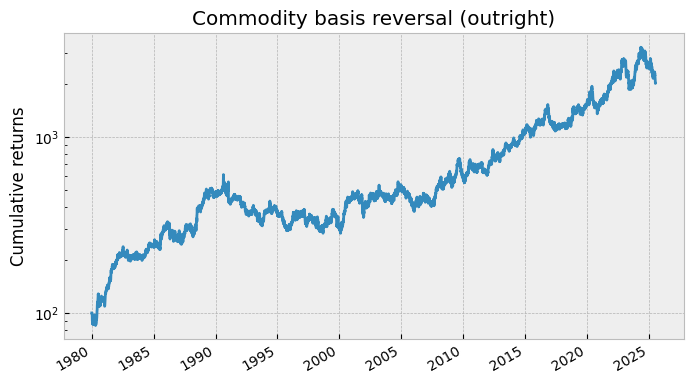

In [5]:
fig, ax = plt.subplots(figsize=(8, 4.5))
outright_return.plot(ax=ax, logy=True);
ax.set_title('Commodity basis reversal (outright)')
ax.set_ylabel('Cumulative returns');

In [6]:
outright_return.pipe(Performance).summary()

,Commodity basis reversal (outright)
CAGR,0.065795
Annualised vol,0.190577
Sharpe ratio,0.345240
Max drawdown,0.535617
Calmar ratio,0.122839
Skewness,-0.321965
Kurtosis,6.717869
Worst return,-0.185764
Worst 1d return,-0.185764
Worst 1w return,-0.114486


## Cross-sectional spread strategy

Similar to the outright basis reversal strategy mentioned above, each commodity is selected based on $SRet_t^{F_1 - F_2}$. However in this case we enter a spread position (short 1st and long 2nd) for commodities with the highest basis reversal signal, and trade the opposite (long 1st and short 2nd) for ones with the lowest signal.

In [7]:
engine_spread = BacktestEngine(
    start_date=datetime(1980, 1, 1),
    strategy=Strategy.DELTA_ONE.value,
    instrument=[InstrumentDef(i, roll_schedule=21, nth_expiry=j, id=f'{i}_{j}') 
                for i, j in product(all_futures_rossi2025.index, [1, 2])],
    signal=signal.XSBasisReversalSpread(
        signal_def={i: (f'{i}_1', f'{i}_2') for i in all_futures_rossi2025.index},
        instr_to_signal={f'{i}_{j}': (f'{i}', False if j == 1 else True) for i, j in product(all_futures_rossi2025.index, [1, 2])},
    ),
    log_level=logging.WARN,
)
engine_spread.run()

In [8]:
spread_return = (engine_spread.calculate_equity_curve(calculate_net=False)
                 .rename('Commodity basis reversal (spread)'))

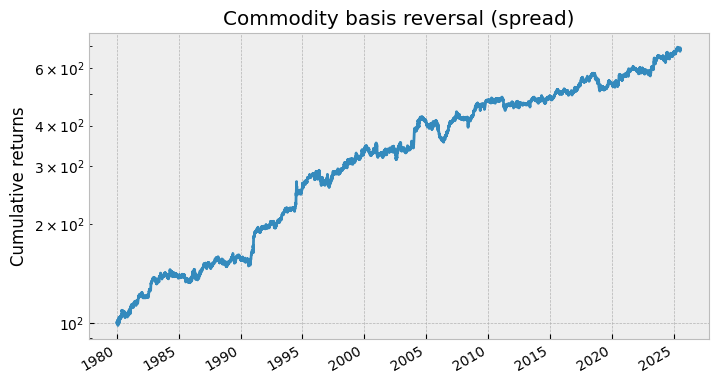

In [9]:
fig, ax = plt.subplots(figsize=(8, 4.5))
spread_return.plot(ax=ax, logy=True);
ax.set_title('Commodity basis reversal (spread)')
ax.set_ylabel('Cumulative returns');

In [10]:
spread_return.pipe(Performance).summary()

,Commodity basis reversal (spread)
CAGR,0.042116
Annualised vol,0.068144
Sharpe ratio,0.618050
Max drawdown,0.165677
Calmar ratio,0.254207
Skewness,0.524605
Kurtosis,10.057104
Worst return,-0.045863
Worst 1d return,-0.045863
Worst 1w return,-0.053319


## Time-series outright strategy

Next we turn to the time-series basis reversal strategy. Instead of looking at the cross-sectional ranking, in this strategy the position for the second contract $F_2$ is determined based on the sign of the spread returns ($SRet_t^{F_1 - F_2}$). Concretely, if the spread return on week $t$ is positive, we take a long position on $F_2$ in the following week and vice versa. 

In [11]:
engine_ts_outright = BacktestEngine(
    start_date=datetime(1980, 1, 1),
    strategy=Strategy.DELTA_ONE.value,
    instrument=[InstrumentDef(i, roll_schedule=21, nth_expiry=2, max_nth_expiry=2) for i in all_futures_rossi2025.index],
    signal=signal.BasisReversal(
        nth_expiry_shift_front=-1, 
        nth_expiry_shift_back=0,
    ),
    weighting=Weighting.EQUAL_WEIGHT.value,
    log_level=logging.WARN,
)
engine_ts_outright.run()

In [12]:
ts_outright_return = (engine_ts_outright.calculate_equity_curve(calculate_net=False)
                      .rename('Time-series commodity basis reversal (outright)'))

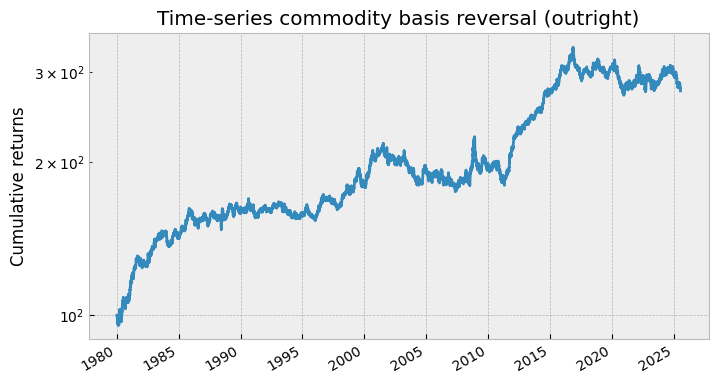

In [13]:
fig, ax = plt.subplots(figsize=(8, 4.5))
ts_outright_return.plot(ax=ax, logy=True);
ax.set_title('Time-series commodity basis reversal (outright)')
ax.set_ylabel('Cumulative returns');

In [14]:
ts_outright_return.pipe(Performance).summary()

,Time-series commodity basis reversal (outright)
CAGR,0.022220
Annualised vol,0.061867
Sharpe ratio,0.359155
Max drawdown,0.197586
Calmar ratio,0.112457
Skewness,0.095081
Kurtosis,3.300066
Worst return,-0.029227
Worst 1d return,-0.029227
Worst 1w return,-0.045212


In [15]:
ts_outright_by_instrument = engine_ts_outright.get_return_by_instrument(calculate_net=False).fillna(0).cumsum()

In [16]:
ts_outright_sharpe = (ts_outright_by_instrument.pipe(Performance, return_type='diff').summary()
                      .loc[PerfStats.SHARPE.value, :]
                      .to_frame().join(all_futures_rossi2025)
                      .set_index('name')
                      .squeeze())

It appears the outright time-series strategy benefited mainly from the soft commodities.

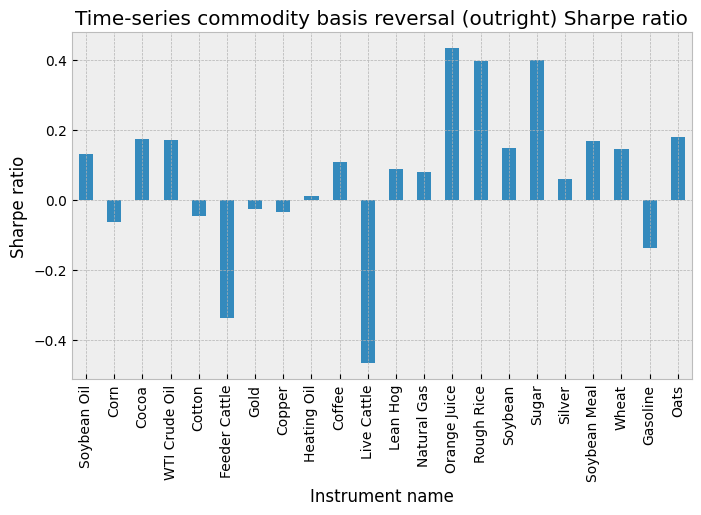

In [17]:
fig, ax = plt.subplots(figsize=(8, 4.5))
ts_outright_sharpe.plot(kind='bar', ax=ax)

ax.set_title('Time-series commodity basis reversal (outright) Sharpe ratio')
ax.set_ylabel(PerfStats.SHARPE.value);
ax.set_xlabel('Instrument name');

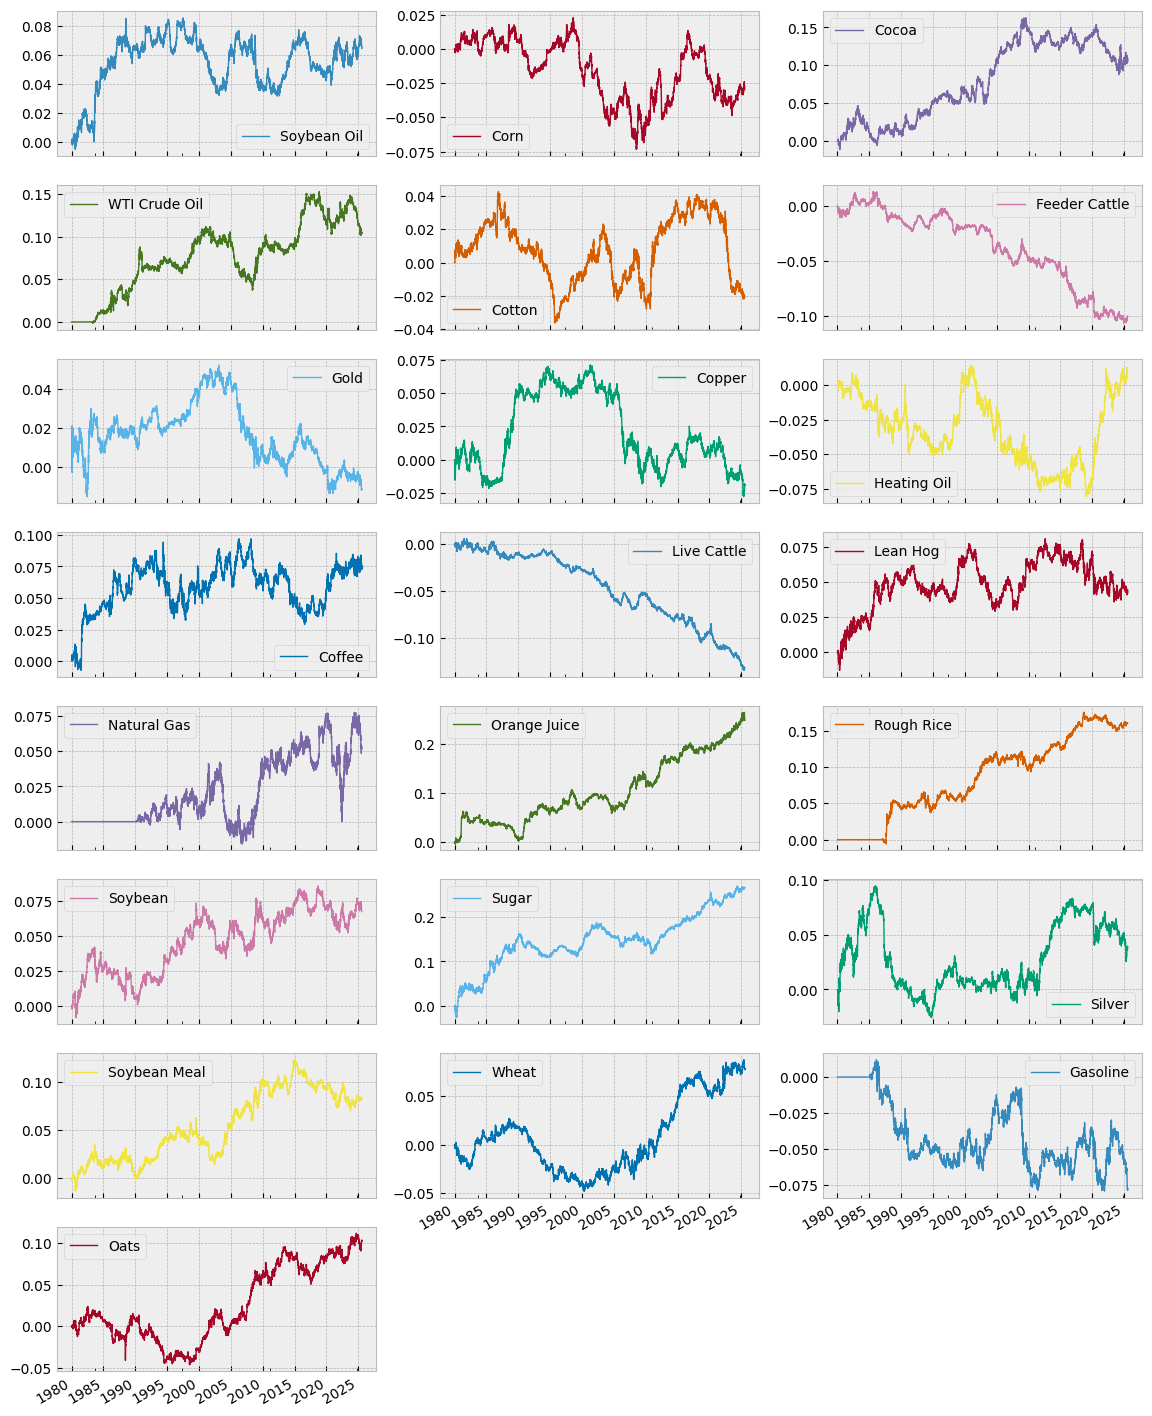

In [18]:
(ts_outright_by_instrument.rename(columns=all_futures_rossi2025.squeeze().to_dict())
 .plot(figsize=(14, 20), subplots=True, lw=1, layout=(8, 3)));

## Time-series spread strategy

In [19]:
engine_ts_spread = BacktestEngine(
    start_date=datetime(1980, 1, 1),
    strategy=Strategy.DELTA_ONE.value,
    instrument=[InstrumentDef(i, roll_schedule=21, nth_expiry=j, id=f'{i}_{j}') 
                for i, j in product(all_futures_rossi2025.index, [1, 2])],
    signal=signal.BasisReversalSpread(
        signal_def={i: (f'{i}_1', f'{i}_2') for i in all_futures_rossi2025.index},
        instr_to_signal={f'{i}_{j}': (f'{i}', False if j == 1 else True) for i, j in product(all_futures_rossi2025.index, [1, 2])},
    ),
    log_level=logging.WARN,
)
engine_ts_spread.run()

In [20]:
ts_spread_return = (engine_ts_spread.calculate_equity_curve(calculate_net=False)
                    .rename('Time-series commodity basis reversal (spread)'))

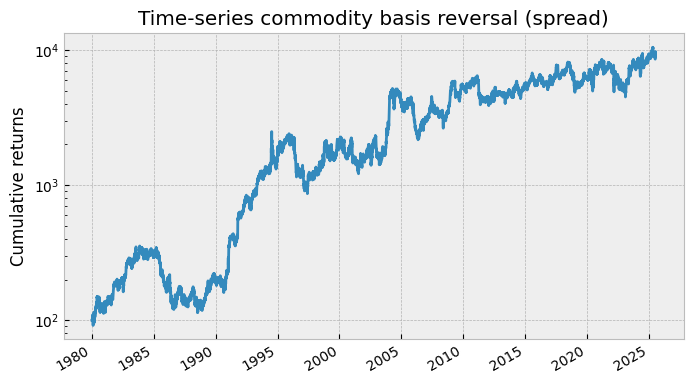

In [21]:
fig, ax = plt.subplots(figsize=(8, 4.5))
ts_spread_return.plot(ax=ax, logy=True);
ax.set_title('Time-series commodity basis reversal (spread)')
ax.set_ylabel('Cumulative returns');

In [22]:
ts_spread_return.pipe(Performance).summary()

,Time-series commodity basis reversal (spread)
CAGR,0.099593
Annualised vol,0.337376
Sharpe ratio,0.295199
Max drawdown,0.677547
Calmar ratio,0.146991
Skewness,0.393924
Kurtosis,8.058588
Worst return,-0.190597
Worst 1d return,-0.190597
Worst 1w return,-0.282967


In [23]:
ts_spread_by_instrument = engine_ts_spread.get_return_by_instrument(calculate_net=False).fillna(0).cumsum()

In [24]:
# combine returns from 1st and 2nd futures
ts_spread_by_instrument = pd.concat([ts_spread_by_instrument.filter(like=f'{i}_').sum(axis=1).rename(i) for i in all_futures_rossi2025.index], axis=1)

In [25]:
ts_spread_sharpe = (ts_spread_by_instrument.pipe(Performance, return_type='diff').summary()
                    .loc[PerfStats.SHARPE.value, :]
                    .to_frame().join(all_futures_rossi2025)
                    .set_index('name')
                    .squeeze())

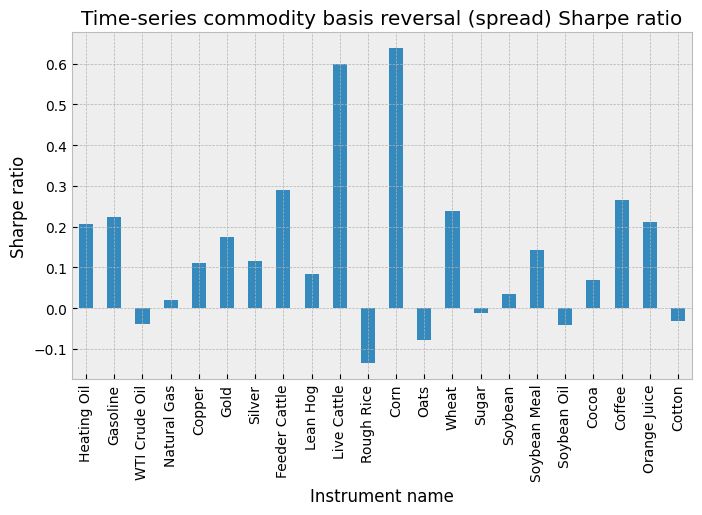

In [26]:
fig, ax = plt.subplots(figsize=(8, 4.5))
ts_spread_sharpe.plot(kind='bar', ax=ax)

ax.set_title('Time-series commodity basis reversal (spread) Sharpe ratio')
ax.set_ylabel(PerfStats.SHARPE.value);
ax.set_xlabel('Instrument name');

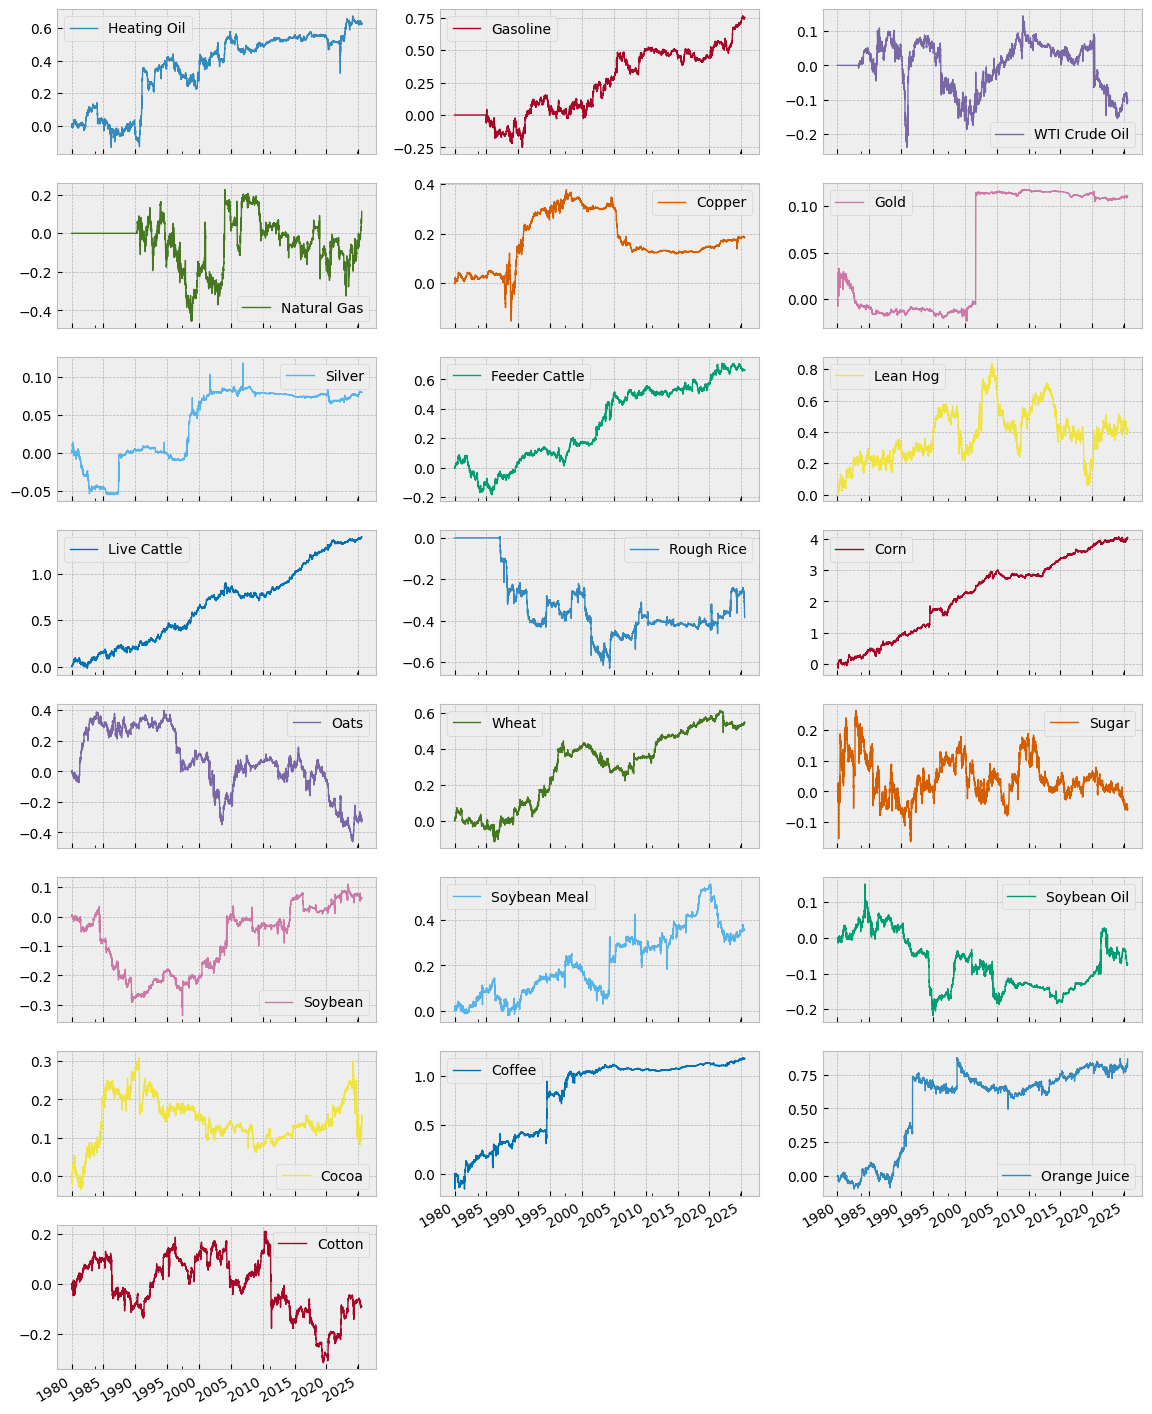

In [27]:
(ts_spread_by_instrument.rename(columns=all_futures_rossi2025.squeeze().to_dict())
 .plot(figsize=(14, 20), subplots=True, lw=1, layout=(8, 3)));

# Post publication

In [28]:
portfolio_return = pd.concat((
    outright_return,
    spread_return,
    ts_outright_return,
    ts_spread_return,
), axis=1)

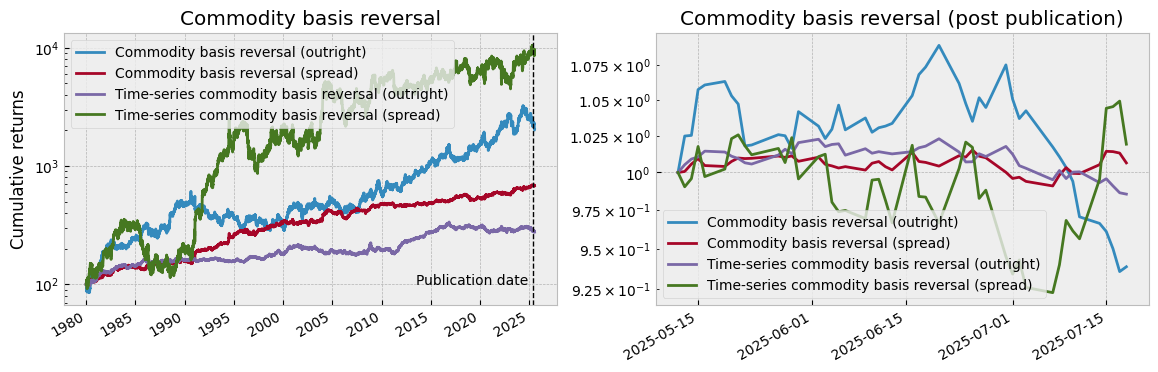

In [29]:
publication_date = datetime(2025, 5, 11)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
portfolio_return.plot(ax=ax[0], logy=True);
ax[0].set_title('Commodity basis reversal')
ax[0].set_ylabel('Cumulative returns');
ax[0].axvline(publication_date, lw=1, ls='--', color='black')
ax[0].text(publication_date, 100, 'Publication date ', ha='right')

portfolio_return.loc[publication_date:].pipe(rebase).plot(ax=ax[1], logy=True);
ax[1].set_title('Commodity basis reversal (post publication)');

# Recent performance

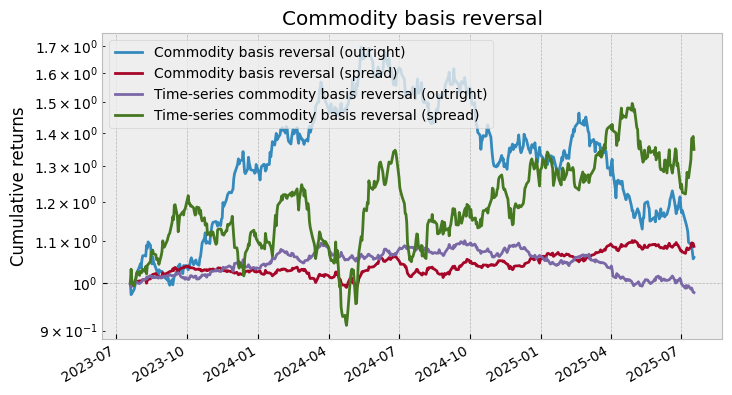

In [30]:
fig, ax = plt.subplots(figsize=(8, 4.5))
portfolio_return.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True);
ax.set_title('Commodity basis reversal')
ax.set_ylabel('Cumulative returns');

# Reference

- Boons, M. and Prado, M.P., 2019. Basis‐momentum. The Journal of Finance, 74(1), pp.239-279.
- Rossi, A.G., Zhang, Y. and Zhu, Y., 2025. Short-Term Basis Reversal. _Available at SSRN 5250499_.

In [31]:
print(f'Updated: {datetime.now(pytz.utc).strftime("%d-%b-%Y %H:%M")}')

Updated: 20-Jul-2025 08:03
